### Open-Source Text to Text Model

Not trained for summarization but Chat & Answering

### Install & Import Necessary Libraries

In [1]:
import time
import sys
sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics
from langchain.prompts import PromptTemplate


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from  langchain import LLMChain, HuggingFacePipeline, PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from sentence_transformers import SentenceTransformer, util
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans


import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Zhang
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def summ_pipeline(model, tokenizer, chain_type, max_length, prompt=False):
  pipeline = transformers.pipeline(
      "text2text-generation",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.bfloat16,
      trust_remote_code=True,
      device_map="auto",
      max_length=max_length,
      do_sample=True,
      top_k=10,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
  )
  llm = HuggingFacePipeline(pipeline = pipeline)


  if chain_type == "map_reduce":
    if prompt:
      prompt_template = """Summarize this: ```{text}```"""
      prompt_message = PromptTemplate(template=prompt_template, input_variables=["text"])
      
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length, map_prompt=prompt_message)
    else:
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length)
  else:
    # can't get it to work with refine and stuff, think they updated the library but no documentation
    # on how to set token_max
    summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type)
  return summary_chain

In [3]:
df = pd.read_excel("../Data/tib_test.xlsx")

df_test = df.head(5)

df_test

,summary,transcript
0,A firsthand look at efforts to improve diversi...,All right. So our next talk is called Hacking...
1,It is certainly a time of discovery- though th...,"Welcome, DEF CON 28, the Do No Harm panel. Th..."
2,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. As you can see from the title o...
3,Stochastic rewriting systems evolving over gra...,"Thank you very much, first important question..."
4,"In typical military operations, the advantage ...",I was great to be with all of you today. I sa...


In [4]:
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens' ,'transcript','original summary', 'summary', 'rouge','bert_score', 'bleu', 'time_taken', 'grammar', 'readability'])

In [5]:
# List of models
models_512 = [
    "google/flan-t5-base",
    "google/flan-t5-large",
]

models_1024 = [

]

df_models_512 = pd.DataFrame(models_512, columns=["Models"])


In [6]:
for model_name in df_models_512['Models']:
    print(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    for index, row in df_test.iterrows():
        method = "MapReduce"
        

        # get the summary
        start_time = time.time()
        max_tokens = tokenizer.model_max_length
        
        summary_chain = summ_pipeline(model, tokenizer, "map_reduce", max_tokens, True)
        print('1')
        # Used for efficient tokenization and processing of long texts when working with language models
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row["transcript"]])

        summary = summary_chain.run(docs)


        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index()
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


google/flan-t5-base
1


Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 100.02it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 2.98 seconds, 0.34 sentences/sec


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16452\2764923580.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)


1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 359.53it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 1.62 seconds, 0.62 sentences/sec
1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.37 seconds, 0.42 sentences/sec
1


Token indices sequence length is longer than the specified maximum sequence length for this model (1212 > 1024). Running this sequence through the model will result in indexing errors
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.22it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.15 seconds, 0.32 sentences/sec
1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 2.13 seconds, 0.47 sentences/sec
google/flan-t5-large
1


Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.10it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 2.66 seconds, 0.38 sentences/sec
1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 533.56it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 1.77 seconds, 0.57 sentences/sec
1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 345.21it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.75 seconds, 0.36 sentences/sec
1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 498.55it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 4.03 seconds, 0.25 sentences/sec
1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.12it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.27 seconds, 0.44 sentences/sec


In [8]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,google/flan-t5-base,MapReduce,512,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,MIT’s Jeremy Peters and Sarah Somers are discu...,"[{'rouge-1': {'r': 0.02976190476190476, 'p': 0...","([tensor(0.8459)], [tensor(0.8010)], [tensor(0...",9.723315e-236,41.102583,"[Offset 30, length 6, Rule ID: MORFOLOGIK_RULE...",100 words required.
1,google/flan-t5-base,MapReduce,512,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,"""DEF Con"" on Dec. 21.","[{'rouge-1': {'r': 0.007874015748031496, 'p': ...","([tensor(0.8517)], [tensor(0.7828)], [tensor(0...",2.243577e-242,44.164815,[],100 words required.
2,google/flan-t5-base,MapReduce,512,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,"""You should have a clearer view of Pompeii, an...","[{'rouge-1': {'r': 0.04285714285714286, 'p': 0...","([tensor(0.8265)], [tensor(0.7688)], [tensor(0...",4.153298e-158,48.918595,[],100 words required.
3,google/flan-t5-base,MapReduce,512,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,The Berkeley Conference is a conference about ...,"[{'rouge-1': {'r': 0.044444444444444446, 'p': ...","([tensor(0.8346)], [tensor(0.7700)], [tensor(0...",2.796185e-160,68.292450,[],100 words required.
4,google/flan-t5-base,MapReduce,512,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",A Deaf Veterans' perspective on cybersecurity,"[{'rouge-1': {'r': 0.007407407407407408, 'p': ...","([tensor(0.8075)], [tensor(0.7777)], [tensor(0...",3.399302e-246,34.339274,[],100 words required.
5,google/flan-t5-large,MapReduce,512,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Douglas Douglas will give a talk about feminis...,"[{'rouge-1': {'r': 0.023809523809523808, 'p': ...","([tensor(0.8181)], [tensor(0.7894)], [tensor(0...",1.534528e-237,131.849959,"[Offset 0, length 15, Rule ID: ENGLISH_WORD_RE...",100 words required.
6,google/flan-t5-large,MapReduce,512,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,The Do No Harm panel is at DEFCON 28.,"[{'rouge-1': {'r': 0.023622047244094488, 'p': ...","([tensor(0.8348)], [tensor(0.7858)], [tensor(0...",4.031086e-240,129.691131,[],100 words required.
7,google/flan-t5-large,MapReduce,512,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,Students learn about the ancient Roman Republi...,"[{'rouge-1': {'r': 0.05, 'p': 0.25, 'f': 0.083...","([tensor(0.8442)], [tensor(0.7736)], [tensor(0...",7.376383e-158,155.554224,[],100 words required.
8,google/flan-t5-large,MapReduce,512,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,"""Is it possible to manipulate trees as structu...","[{'rouge-1': {'r': 0.016666666666666666, 'p': ...","([tensor(0.8444)], [tensor(0.7671)], [tensor(0...",1.132761e-243,148.562496,[],100 words required.
9,google/flan-t5-large,MapReduce,512,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...","""The U.S. Air Force's Chief Information Office...","[{'rouge-1': {'r': 0.08148148148148149, 'p': 0...","([tensor(0.8522)], [tensor(0.8114)], [tensor(0...",3.568590e-80,137.609319,"[Offset 0, length 1, Rule ID: EN_UNPAIRED_BRAC...",100 words required.


In [9]:
df_scores.to_excel("./result/open_source_model_t2t.xlsx", index=False)

C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16452\2086916961.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16452\2086916961.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_16452\2086916961.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


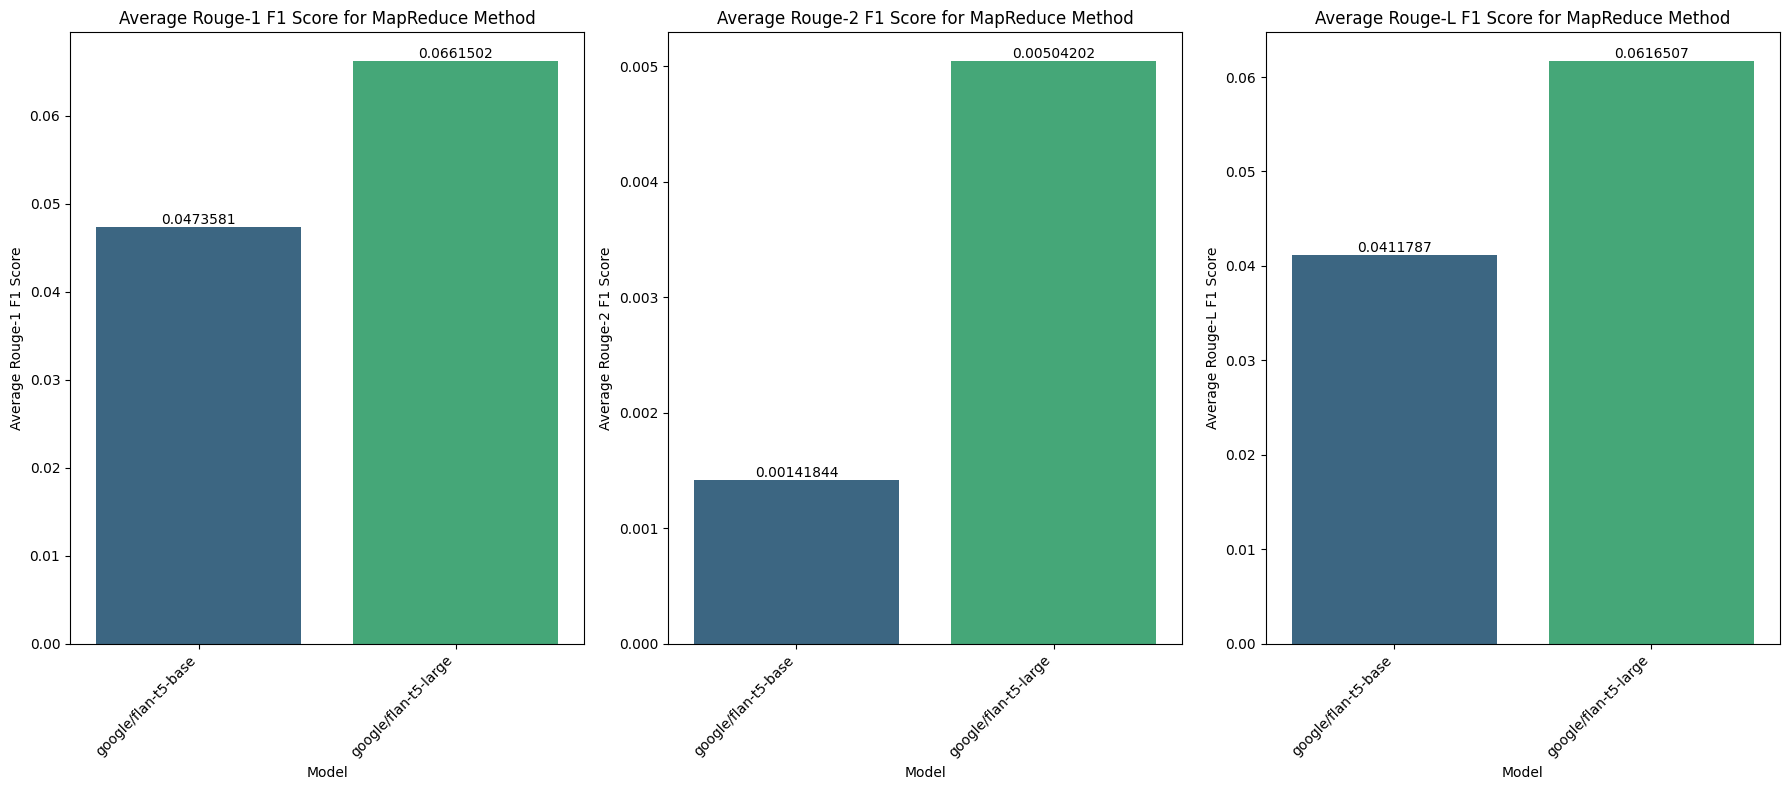

In [10]:
# Convert string representation of dict to a dictionary
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: x[0])

# Extract Rouge-1, Rouge-2, and Rouge-L F1 scores from the dictionary
df_scores['rouge-1_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-1']['f'])
df_scores['rouge-2_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-2']['f'])
df_scores['rouge-l_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-l']['f'])

# Filter data for MapReduce method
df_scores_mapreduce = df_scores[df_scores['method'] == 'MapReduce']

# Calculate the average of Rouge-1, Rouge-2, and Rouge-L F1 scores for each model
avg_rouge1 = df_scores_mapreduce.groupby('model')['rouge-1_f'].mean().reset_index()
avg_rouge2 = df_scores_mapreduce.groupby('model')['rouge-2_f'].mean().reset_index()
avg_rouge_l = df_scores_mapreduce.groupby('model')['rouge-l_f'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot Charts
sns.barplot(x='model', y='rouge-1_f', data=avg_rouge1, palette='viridis', ax=axes[0], hue='model')
axes[0].set_title('Average Rouge-1 F1 Score for MapReduce Method')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Average Rouge-1 F1 Score')
# axes[0].tick_params(axis='x', labelrotation = 45)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

for container in axes[0].containers:
    axes[0].bar_label(container)

sns.barplot(x='model', y='rouge-2_f', data=avg_rouge2, palette='viridis', ax=axes[1], hue='model')
axes[1].set_title('Average Rouge-2 F1 Score for MapReduce Method')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Average Rouge-2 F1 Score')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
for container in axes[1].containers:
    axes[1].bar_label(container)

sns.barplot(x='model', y='rouge-l_f', data=avg_rouge_l, palette='viridis', ax=axes[2], hue='model')
axes[2].set_title('Average Rouge-L F1 Score for MapReduce Method')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Average Rouge-L F1 Score')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
for container in axes[2].containers:
    axes[2].bar_label(container)




plt.tight_layout()

plt.show()